## Setup Environment

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/DL-Project

# # Set Working Directory
# !ln -s "/content/drive/My Drive/Colab Notebooks/DL-Project" /content/DL-Project
# %cd /content/drive/My Drive/Colab Notebooks/DL-Project


/content/drive/My Drive/Colab Notebooks/DL-Project


In [3]:
! pip install transformers
! pip install pycaret
! pip install squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.3 MB/s eta 0:0

In [4]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import torch
import torch.nn as nn
import seaborn as sns
import os
from benchmark import train, evaluate, find_accuracy, benchmark_1, plot
# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [5]:
import os
import pandas as pd

# Construct the file path
data_file = os.path.join('/content/drive/MyDrive/Colab Notebooks/DL-Project/Data', 'final_fake_news.csv')

# Load the CSV file
data = pd.read_csv(data_file)

# Verify DataFrame
print(data.head())

# Check the column names
print(data.columns)


                                          text;label
0  republican committee pass bill would prohibit ...
1  trump treasury candidate bank accuse discrimin...
2  guess behind sicken ad show boy bully dad vote...
3  michigan treasurer call quick action detroit s...
4  clinton urge renew fight value washington reut...
Index(['text;label'], dtype='object')


In [6]:
print(os.getcwd())
data = pd.read_csv('Data/final_fake_news.csv', delimiter=';')
data['Target'] = 'True'
data.loc[data['label'] == 0, 'Target'] = 'Fake'
data = data.sample(frac=1).reset_index().drop(columns=['index'])

# True/Fake to numbers 0/1 (Fake=1)
# data['label'] = pd.get_dummies(data.Target)['Fake']
print(data.shape)
data.head()

/content/drive/MyDrive/Colab Notebooks/DL-Project
(39409, 3)


,text,label,Target
0,two injured shoot south africa cape town airpo...,1,True
1,mn somali muslim immigrant explain acceptable ...,0,Fake
2,one age full video transcript trump incredible...,0,Fake
3,trump totally screw military child one one don...,0,Fake
4,oklahoma bomb anniversary pitch garland suprem...,1,True


In [7]:
# True/Fake to numbers 0/1 (Fake=1)
# data['label'] = pd.get_dummies(data.Target)['Fake']

In [8]:
data.head()

,text,label,Target
0,two injured shoot south africa cape town airpo...,1,True
1,mn somali muslim immigrant explain acceptable ...,0,Fake
2,one age full video transcript trump incredible...,0,Fake
3,trump totally screw military child one one don...,0,Fake
4,oklahoma bomb anniversary pitch garland suprem...,1,True


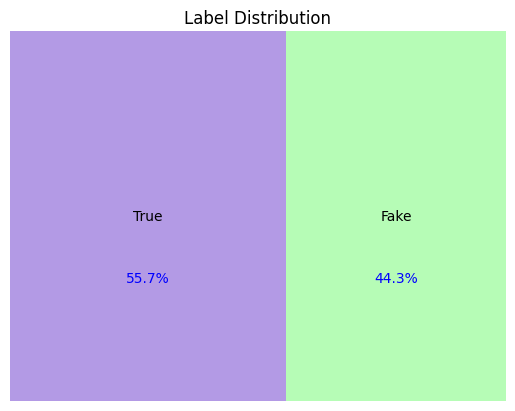

In [9]:
import matplotlib.pyplot as plt
import squarify

true_count = (data['Target'] == "True").sum()
fake_count = (data['Target'] == "Fake").sum()

label_size = true_count, fake_count
# label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]

labels = ['True', 'Fake']
colors = ['#9370DB', '#98FB98']

fig, ax = plt.subplots()
squarify.plot(sizes=label_size, label=labels, color=colors, alpha=0.7, ax=ax)

plt.title('Label Distribution')
plt.axis('off')

for i, rect in enumerate(ax.patches):
    percentage = label_size[i] / sum(label_size) * 100
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_y() + rect.get_height() / 3
    plt.text(x=x, y=y, s=f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='blue')

plt.show()

## Train-test-split

In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [11]:
# Load BERT model and tokenizer
#bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

In [12]:
# Get the vocabulary
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
# Print the size of the vocabulary
print("Vocabulary size: ", len(vocab))

Vocabulary size:  30522


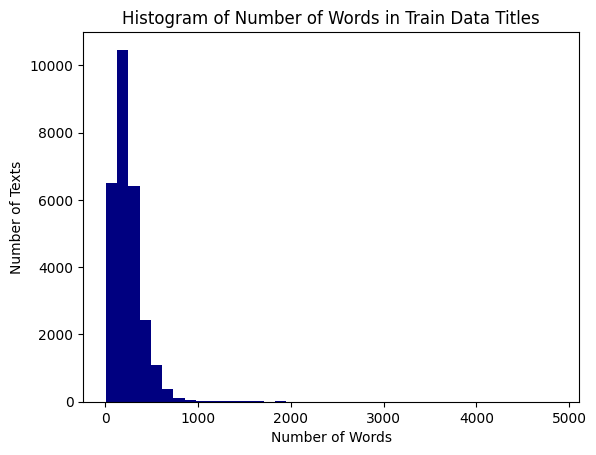

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of words in each title
seq_len = [len(title.split()) for title in train_text]

plt.hist(seq_len, bins=40, color='navy')

plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.title('Histogram of Number of Words in Train Data Titles')

# Show the plot
plt.show()

In [14]:
#Set hyperparameters
vocab_size = len(vocab)
MAX_LENGHT = 15
batch_size = 32
PAD_IDX = 0
output_size = 1

#LSTM param
embedding_dim = 64  # Size of the word embeddings
hidden_dim = 128  # Size of the hidden state in the LSTM
num_layers = 3  # Number of LSTM layers
dropout = 0.3  # Dropout rate


learning_rate = 1e-5
l2norm=0.1
EPOCHS = 20

model_path = 'model_LSTM_v4.pt'

In [15]:
# Set max title length

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
print(train_text[0:5])
print(tokens_train[0:10])

31465    naked man rant trump time square know trump su...
34570    u say turkish gold trader face iran trial invo...
34081    mock assassination donald trump spark outrage ...
13941    racist liberal reporter arrest connection jewi...
21487    video obama lecture iran everything chant deat...
Name: text, dtype: object
[Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=15, attributes=[ids, type_ids, tokens, offsets, attention_

In [16]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [17]:
with open('output.txt', "w+") as file:
    file.write(str(tokens_train['input_ids']))

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

### Define Model Architecture

In [19]:
import numpy as np
import torch
from torch import nn
import random

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, bidirectional=True, batch_first=True).to(device)
        self.fc1 = nn.Linear(hidden_dim * 2, 128).to(device)  # doubled hidden_dim due to bidirectional
        self.fc2 = nn.Linear(128, 64).to(device)
        self.fc3 = nn.Linear(64, 1).to(device)  # Reduced output units
        self.dropout1 = nn.Dropout(dropout).to(device)
        self.dropout2 = nn.Dropout(dropout).to(device)
        self.leaky_relu = nn.LeakyReLU().to(device)  # Use LeakyReLU instead of ReLU
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim * 2).to(device)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim * 2, num_heads=4).to(device)  # Attention mechanism with 4 heads

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)

        # Attention mechanism
        lstm_out = lstm_out.permute(1, 0, 2)  # Swap batch_size and sequence_length dimensions
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out = lstm_out + attn_out
        lstm_out = lstm_out.permute(1, 0, 2)  # Swap back to original shape

        final_time_step_out = lstm_out[:, -1, :]
        final_time_step_out = self.batchnorm1(final_time_step_out)
        fc1_out = self.fc1(final_time_step_out)
        fc1_out = self.leaky_relu(fc1_out)  # Apply LeakyReLU activation
        fc1_out = self.dropout1(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.leaky_relu(fc2_out)  # Apply LeakyReLU activation
        fc2_out = self.dropout2(fc2_out)
        fc3_out = self.fc3(fc2_out).squeeze(-1)
        return fc3_out

### Define Train & Evaluate Function

In [20]:
from tqdm import tqdm_notebook

def train(model, dataloader, optimizer, criterion, scheduler=None, device='cpu'):
    model.train()

    # Record total loss
    total_loss = 0.

    # Get the progress bar for later modification
    progress_bar = tqdm_notebook(dataloader, ascii=True)

    # Mini-batch training
    for batch_idx, data in enumerate(progress_bar):
        source = data[0].to(device)
        mask = data[1].to(device)
        target = data[2].unsqueeze(1).to(device)
        translation = model(source)

        optimizer.zero_grad()
        translation = translation.unsqueeze(1)
        target = target.float()
        loss = criterion(translation, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_description_str(
            "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

    return total_loss, total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device='cpu'):
    # Set the model to eval mode to avoid weights update
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source)
            translation = translation.unsqueeze(1)
            target = target.float()
            loss = criterion(translation, target)
            total_loss += loss.item()
            progress_bar.set_description_str(
                "Batch: %d, Loss: %.4f" % ((batch_idx + 1), loss.item()))

    avg_loss = total_loss / len(dataloader)
    return total_loss, avg_loss

def find_accuracy(model, dataloader, device):
    # Set the model to eval mode to avoid weights update
    model.eval()
    correct_pred = 0
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source)
            translation = translation.unsqueeze(1)
            pred = (translation > 0).int()
            target = target.float()
            correct_items = ((pred == target).int()).sum().item()
            correct_pred += correct_items
            progress_bar.set_description_str(
                "Batch: %d, Correct items: %.4f" % ((batch_idx + 1), correct_items))
    accuracy = correct_pred / (len(dataloader)*batch_size)
    return accuracy

In [21]:
#from utils import evaluate, set_seed_nb, unit_test_values, deterministic_init
import matplotlib.pyplot as plt
# input size and output size
input_size = vocab_size

print(f"DEBUG: device:{device}")
# Model

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)

DEBUG: device:cuda


-----------------------------------
Epoch 1
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.6901. Validation Loss: 0.6751. 
Training Perplexity: 1.9939. Validation Perplexity: 1.9642. 
Training Acc: 0.7413. Validation Acc: 0.7390. 
Saved model
-----------------------------------
Epoch 2
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.6649. Validation Loss: 0.6381. 
Training Perplexity: 1.9442. Validation Perplexity: 1.8929. 
Training Acc: 0.7981. Validation Acc: 0.8005. 
Saved model
-----------------------------------
Epoch 3
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.5997. Validation Loss: 0.5317. 
Training Perplexity: 1.8216. Validation Perplexity: 1.7019. 
Training Acc: 0.8470. Validation Acc: 0.8475. 
Saved model
-----------------------------------
Epoch 4
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4948. Validation Loss: 0.4469. 
Training Perplexity: 1.6401. Validation Perplexity: 1.5635. 
Training Acc: 0.8527. Validation Acc: 0.8554. 
Saved model
-----------------------------------
Epoch 5
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4349. Validation Loss: 0.4043. 
Training Perplexity: 1.5448. Validation Perplexity: 1.4983. 
Training Acc: 0.8616. Validation Acc: 0.8666. 
Saved model
-----------------------------------
Epoch 6
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.4085. Validation Loss: 0.3888. 
Training Perplexity: 1.5046. Validation Perplexity: 1.4751. 
Training Acc: 0.8667. Validation Acc: 0.8696. 
Saved model
-----------------------------------
Epoch 7
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3938. Validation Loss: 0.3697. 
Training Perplexity: 1.4826. Validation Perplexity: 1.4473. 
Training Acc: 0.8695. Validation Acc: 0.8715. 
Saved model
-----------------------------------
Epoch 8
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3851. Validation Loss: 0.3695. 
Training Perplexity: 1.4698. Validation Perplexity: 1.4470. 
Training Acc: 0.8683. Validation Acc: 0.8725. 
Saved model
-----------------------------------
Epoch 9
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3788. Validation Loss: 0.3523. 
Training Perplexity: 1.4606. Validation Perplexity: 1.4224. 
Training Acc: 0.8717. Validation Acc: 0.8725. 
Saved model
-----------------------------------
Epoch 10
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3711. Validation Loss: 0.3567. 
Training Perplexity: 1.4494. Validation Perplexity: 1.4286. 
Training Acc: 0.8723. Validation Acc: 0.8753. 
-----------------------------------
Epoch 11
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3685. Validation Loss: 0.3525. 
Training Perplexity: 1.4455. Validation Perplexity: 1.4226. 
Training Acc: 0.8726. Validation Acc: 0.8760. 
-----------------------------------
Epoch 12
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3649. Validation Loss: 0.3519. 
Training Perplexity: 1.4404. Validation Perplexity: 1.4217. 
Training Acc: 0.8727. Validation Acc: 0.8765. 
Saved model
-----------------------------------
Epoch 13
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3637. Validation Loss: 0.3582. 
Training Perplexity: 1.4386. Validation Perplexity: 1.4308. 
Training Acc: 0.8725. Validation Acc: 0.8758. 
-----------------------------------
Epoch 14
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3634. Validation Loss: 0.3429. 
Training Perplexity: 1.4383. Validation Perplexity: 1.4090. 
Training Acc: 0.8743. Validation Acc: 0.8784. 
Saved model
-----------------------------------
Epoch 15
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3600. Validation Loss: 0.3428. 
Training Perplexity: 1.4334. Validation Perplexity: 1.4088. 
Training Acc: 0.8740. Validation Acc: 0.8765. 
Saved model
-----------------------------------
Epoch 16
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3610. Validation Loss: 0.3446. 
Training Perplexity: 1.4348. Validation Perplexity: 1.4114. 
Training Acc: 0.8740. Validation Acc: 0.8782. 
-----------------------------------
Epoch 17
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3597. Validation Loss: 0.3490. 
Training Perplexity: 1.4329. Validation Perplexity: 1.4177. 
Training Acc: 0.8721. Validation Acc: 0.8748. 
-----------------------------------
Epoch 18
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3602. Validation Loss: 0.3453. 
Training Perplexity: 1.4336. Validation Perplexity: 1.4124. 
Training Acc: 0.8736. Validation Acc: 0.8757. 
-----------------------------------
Epoch 19
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3593. Validation Loss: 0.3455. 
Training Perplexity: 1.4323. Validation Perplexity: 1.4127. 
Training Acc: 0.8707. Validation Acc: 0.8726. 
-----------------------------------
Epoch 20
-----------------------------------


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Training Loss: 0.3610. Validation Loss: 0.3430. 
Training Perplexity: 1.4348. Validation Perplexity: 1.4091. 
Training Acc: 0.8751. Validation Acc: 0.8779. 


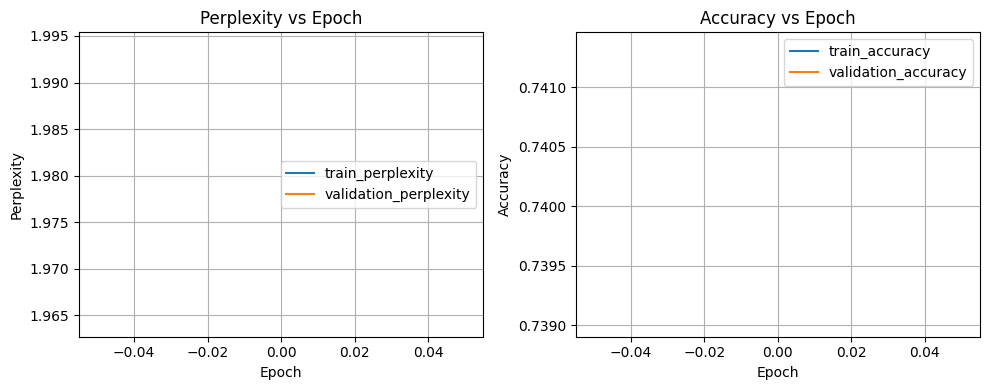

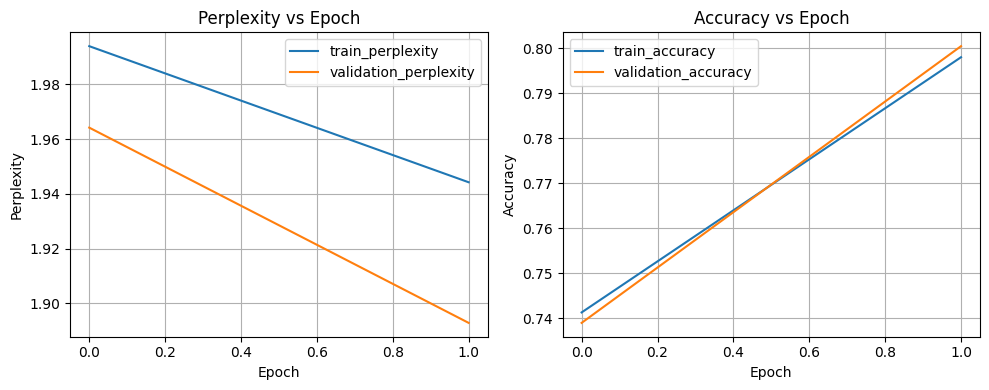

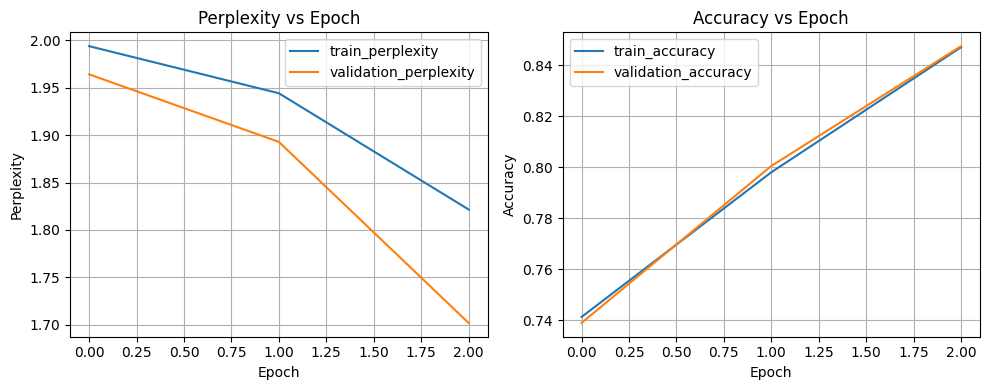

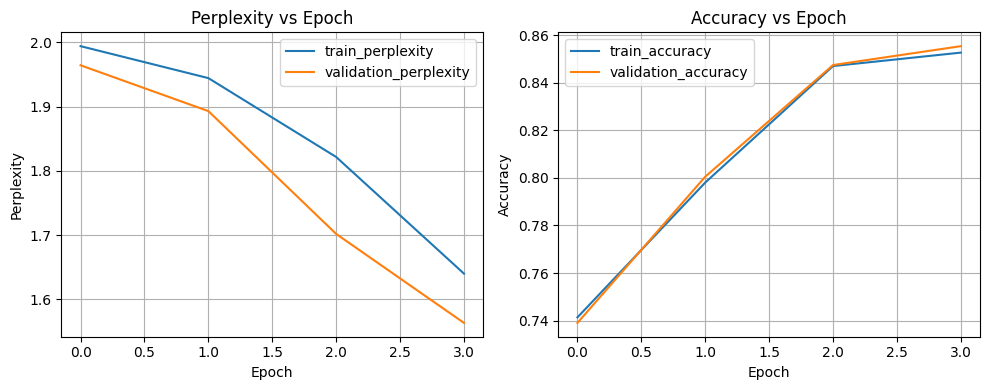

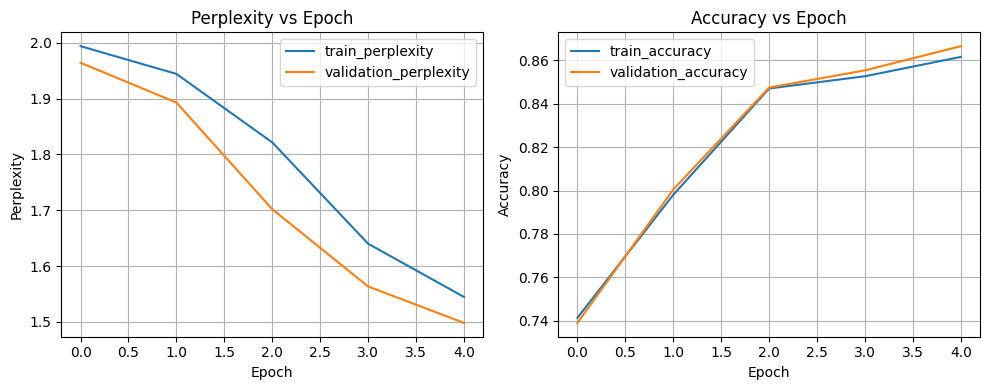

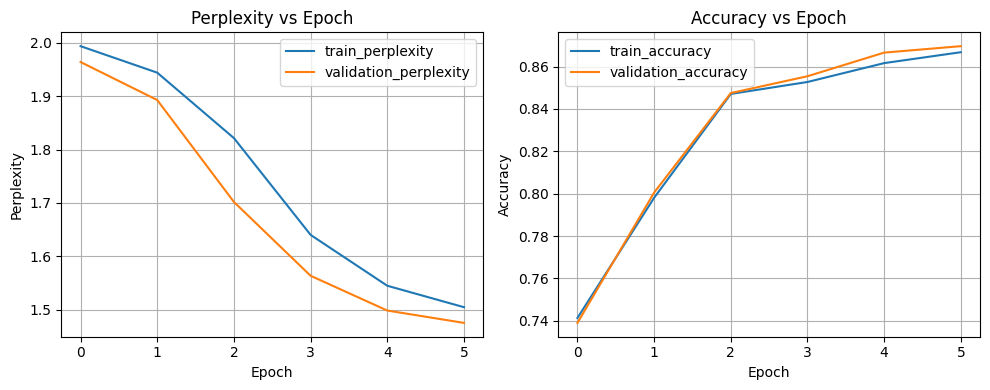

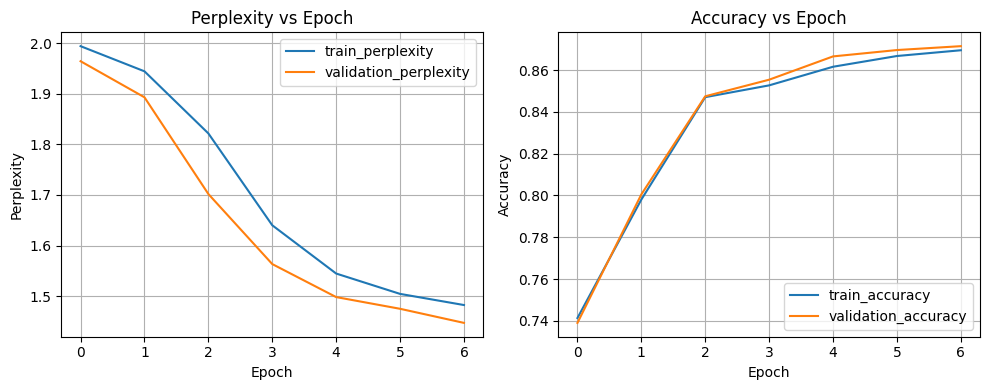

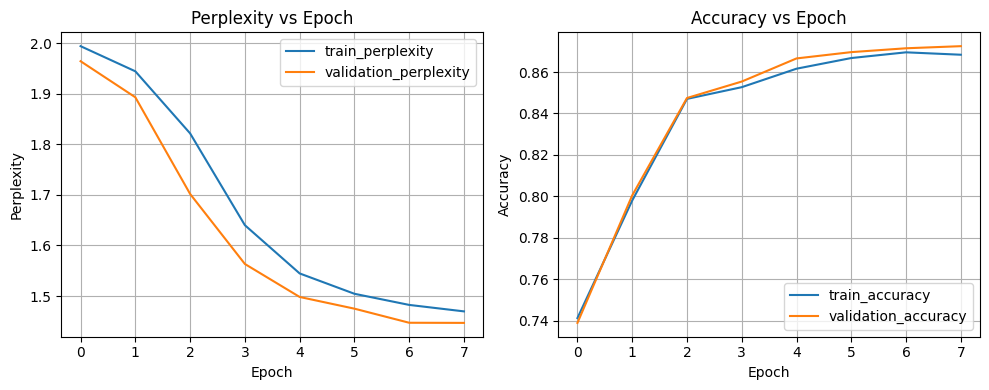

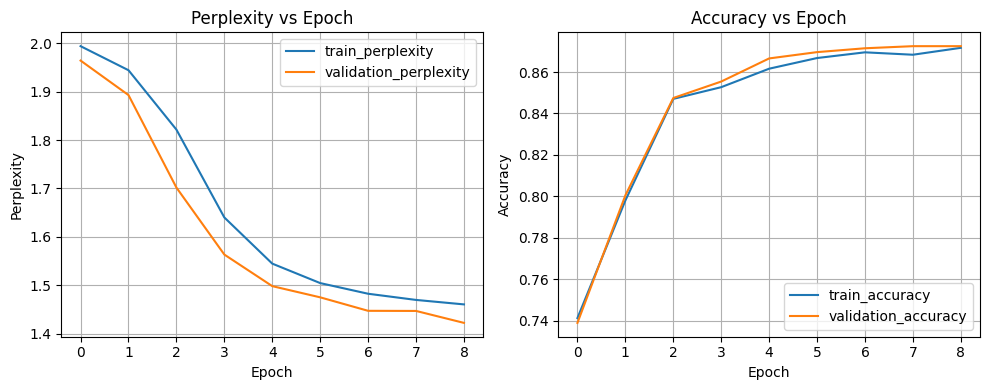

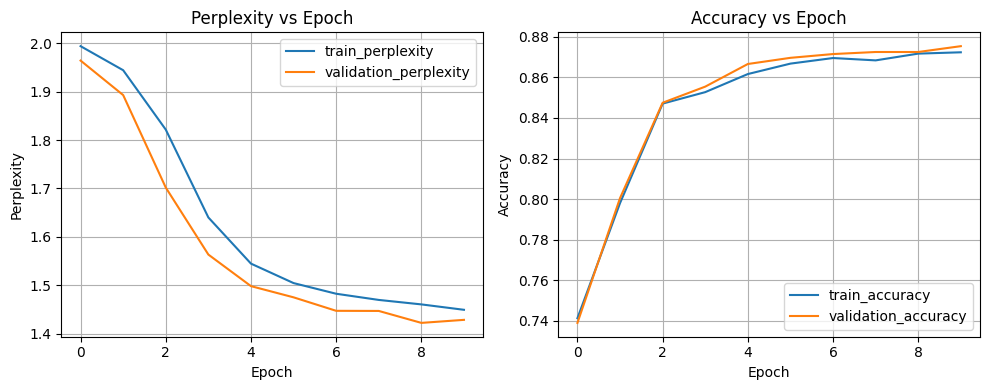

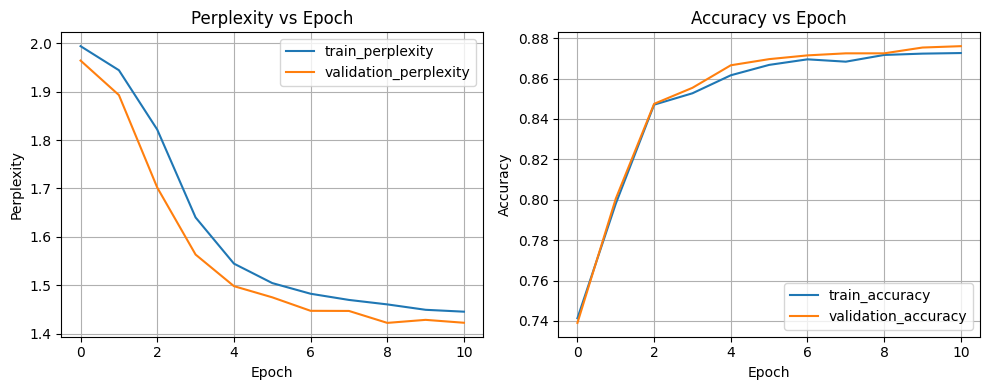

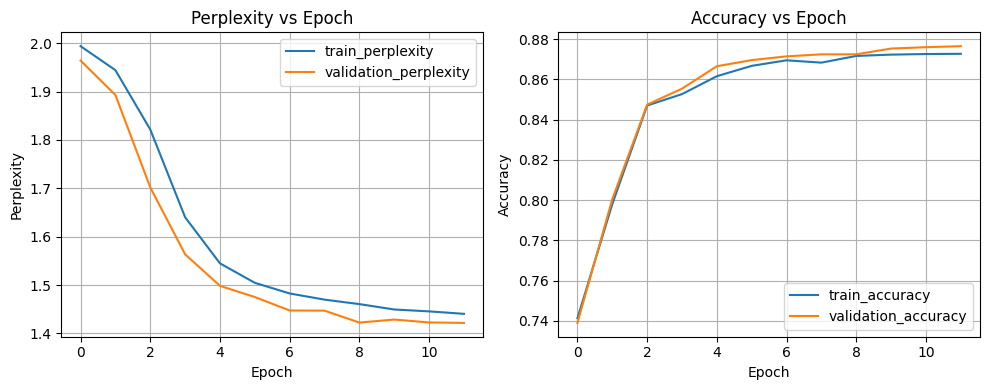

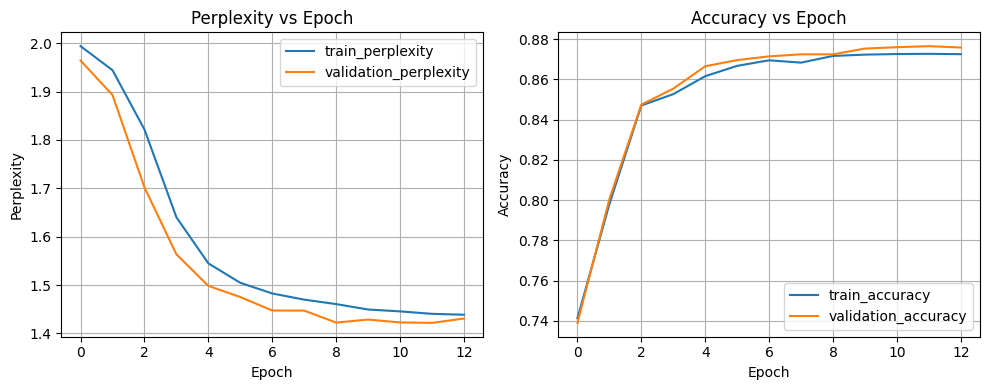

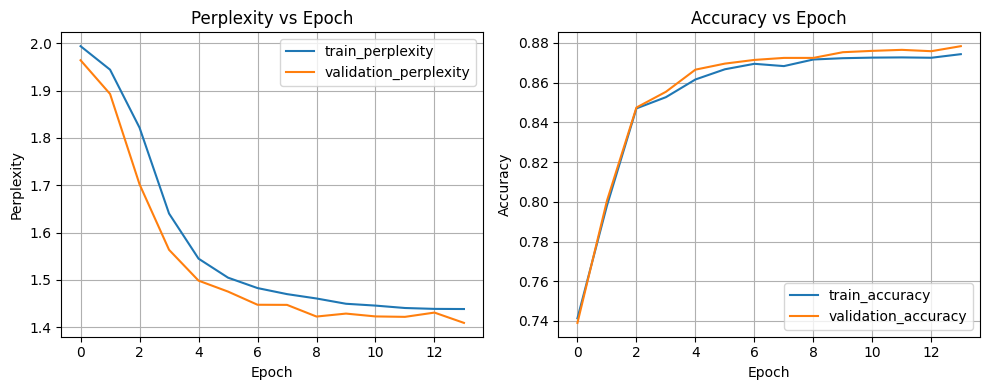

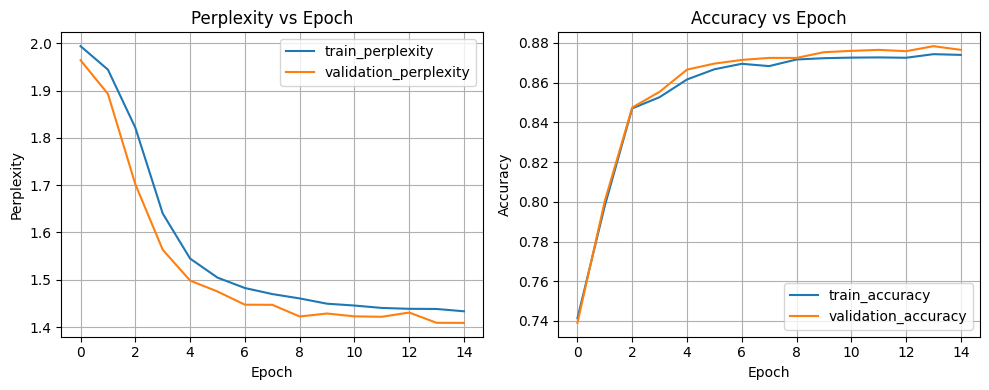

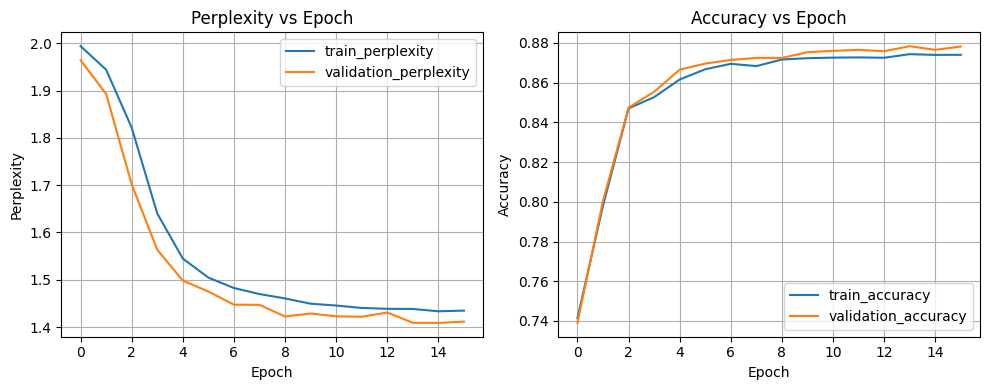

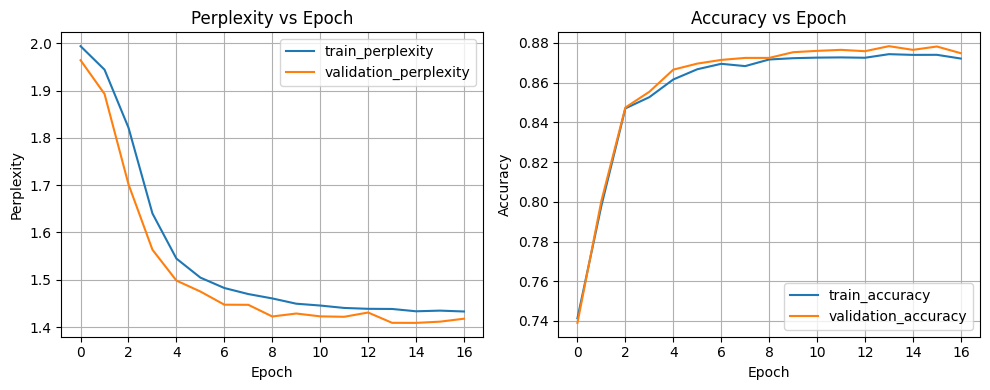

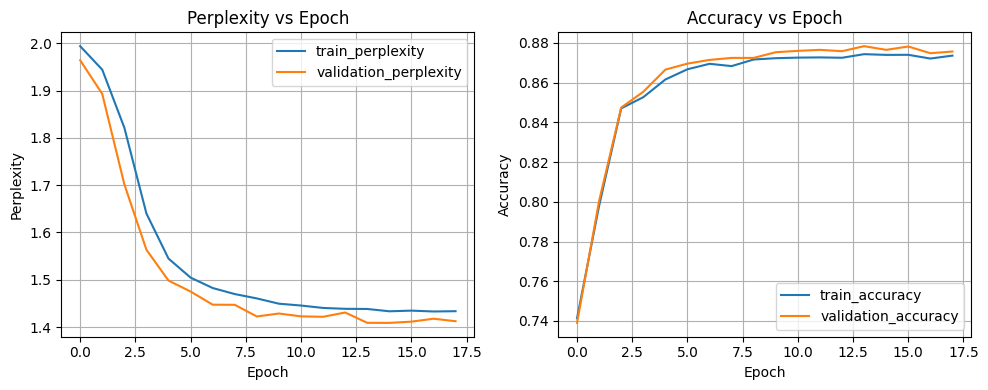

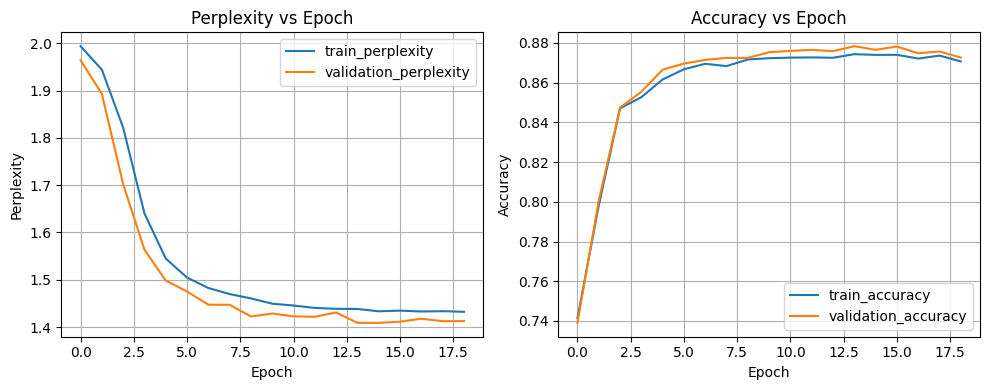

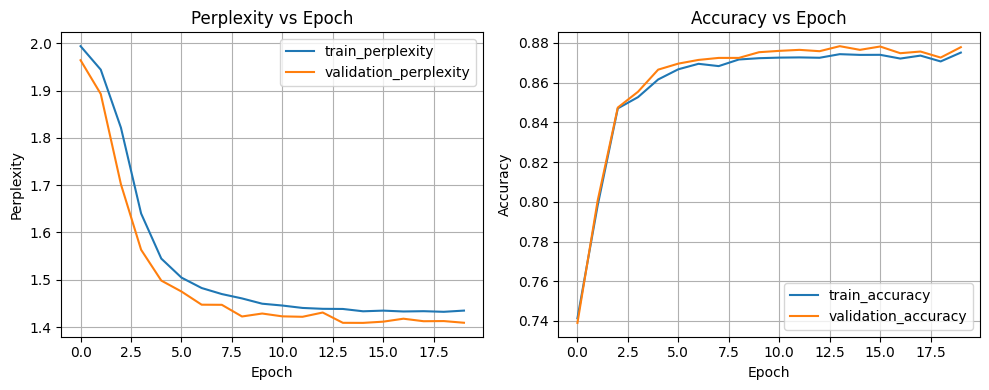

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2norm)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.BCEWithLogitsLoss()
train_per = []
valid_per = []
train_acc_list = []
val_acc_list = []
lowest_loss = 10000
for epoch_idx in range(EPOCHS):
    print("-----------------------------------")
    print("Epoch %d" % (epoch_idx+1))
    print("-----------------------------------")

    train_loss, avg_train_loss = train(
        model, train_dataloader, optimizer, criterion, device=device)
    scheduler.step(train_loss)

    val_loss, avg_val_loss = evaluate(
        model, val_dataloader, criterion, device=device)

    acc_train = find_accuracy(model, train_dataloader, device=device)
    acc_val = find_accuracy(model, val_dataloader, device=device)
    print("Training Loss: %.4f. Validation Loss: %.4f. " %
          (avg_train_loss, avg_val_loss))
    print("Training Perplexity: %.4f. Validation Perplexity: %.4f. " %
          (np.exp(avg_train_loss), np.exp(avg_val_loss)))
    print("Training Acc: %.4f. Validation Acc: %.4f. " %
          (acc_train, acc_val))

    if np.exp(avg_val_loss) < lowest_loss:
        torch.save(model.state_dict(), model_path)
        lowest_loss = np.exp(avg_val_loss)
        print("Saved model")

    train_per.append(np.exp(avg_train_loss))
    valid_per.append(np.exp(avg_val_loss))

    train_acc_list.append(acc_train)
    val_acc_list.append(acc_val)

    x_dim = list(range(epoch_idx+1))

    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.plot(x_dim, train_per, label='train_perplexity')
    ax1.plot(x_dim, valid_per, label='validation_perplexity')
    ax1.set_title('Perplexity vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Perplexity')
    ax1.grid(True)
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(x_dim, train_acc_list, label='train_accuracy')
    ax2.plot(x_dim, val_acc_list, label='validation_accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('perplexity_LSTM_final.png')

In [23]:
# Simply running validation step
input_size = vocab_size

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
criterion = nn.BCEWithLogitsLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
val_loss, avg_val_loss = evaluate(
        model, val_dataloader, criterion, device=device)
acc = find_accuracy(
        model, val_dataloader, device=device)
print("Validation Loss: %.4f. " %(avg_val_loss))
print("Validation Perplexity: %.4f. " %(np.exp(avg_val_loss)))
print("Validation Accuracy: %.4f. " %(acc))

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Validation Loss: 0.3428. 
Validation Perplexity: 1.4088. 
Validation Accuracy: 0.8765. 


In [24]:
# Simply running test step
input_size = vocab_size

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)

if device == 'cuda':
  model.load_state_dict(torch.load(model_path))
else:
  model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

test_loss, avg_test_loss = evaluate(
        model, test_dataloader, criterion, device=device)

acc = find_accuracy(model, test_dataloader, device=device)
print("Test Loss: %.4f. " %(avg_test_loss))
print("Test Perplexity: %.4f. " %(np.exp(avg_test_loss)))
print("Test accuracy: %.4f. " %(acc))

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

Test Loss: 0.3513. 
Test Perplexity: 1.4209. 
Test accuracy: 0.8637. 


In [27]:
# Load the saved state_dict into the model
model_path = 'model_LSTM_v4.pt'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Unseen data
unseen_news_text_random = ["A precautionary message that one can catch fire due to hand sanitizer as it has a high amount of alcohol. The message also shows the hands of a lady who after applying sanitizer went near the stove and ended up burning her hands.",  # Fake
                    "A Pentagon study found that people who get the flu vaccine are 36% more likely to get COVID-19.",               # Fake
                    "The total number of confirmed cases of COVID-19 is now 1212 which is the number we report to the World Health Organization. There is no one in New Zealand receiving hospital-level care for COVID-19.",           # True
                    "Our total number of confirmed cases remains at 1205 which is the number we report to the World Health Organization."                          # True
                    ]

# Tokenize and encode sequences in the test set
MAX_LENGTH = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text_random,
    max_length=MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'  # Returns PyTorch tensors
)

# # Pass the encoded input to the model for predictions
# with torch.no_grad():
#     input_ids = tokens_unseen['input_ids']
#     preds = model(input_ids)
#     preds = preds.squeeze(-1).detach().cpu().numpy()

with torch.no_grad():
    input_ids = tokens_unseen['input_ids'].to('cuda:0')  # Move input tensor to GPU
    preds = model(input_ids)
    preds = preds.squeeze(-1).detach().cpu().numpy()

# Convert the predictions to class labels (0 or 1)
preds_labels = (preds > 0.5).astype(int)

# print(preds_labels)

In [28]:
# Function to get model predictions and true labels
def get_predictions_and_labels(model, dataloader, device='cpu'):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            predictions = model(source)
            predictions = (predictions > 0).int()  # Convert logits to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

# # Get predictions and true labels
# predictions, labels = get_predictions_and_labels(model, test_dataloader, device)

# # Calculate confusion matrix and classification report
# conf_matrix = confusion_matrix(labels, predictions)
# class_report = classification_report(labels, predictions)

# print("Confusion Matrix:")
# print(conf_matrix)
# print("\nClassification Report:")
# print(class_report)

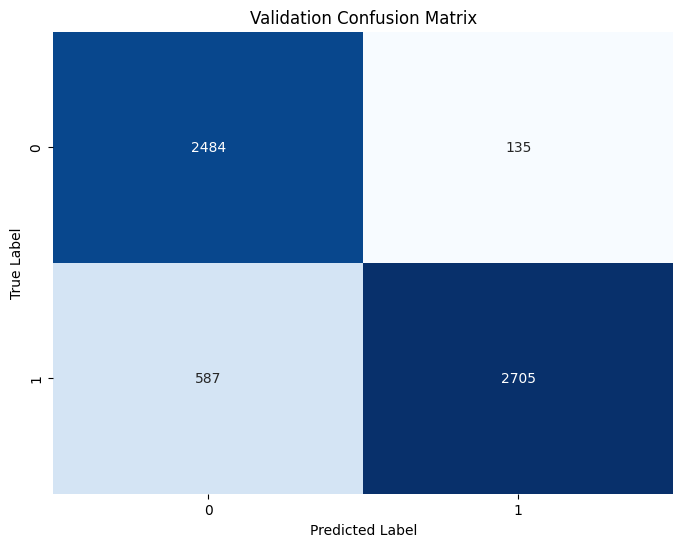

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87      2619
           1       0.95      0.82      0.88      3292

    accuracy                           0.88      5911
   macro avg       0.88      0.89      0.88      5911
weighted avg       0.89      0.88      0.88      5911



In [29]:
# Function to get model predictions and true labels
def get_predictions_and_labels(model, dataloader, device='cpu'):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            predictions = model(source)
            predictions = (predictions > 0).int()  # Convert logits to binary predictions
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)

# Get predictions and true labels for validation data
val_predictions, val_labels = get_predictions_and_labels(model, val_dataloader, device)

# Calculate confusion matrix for validation data
conf_matrix_val = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix heatmap for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report for validation data
val_report = classification_report(val_labels, val_predictions)
print("Validation Classification Report:")
print(val_report)
